In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# 혈당 데이터 유의성 찾기

In [12]:

df = pd.read_csv("국민건강보험공단_건강검진정보_2024.CSV", encoding="cp949")

In [13]:
df = pd.read_csv("국민건강보험공단_건강검진정보_2024.CSV", encoding="cp949")
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)  
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   


num_cols = [
    '신장(5cm단위)', '체중(5kg단위)', '허리둘레', '수축기혈압', '이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피'
]
cat_cols = ['성별코드','흡연상태','음주여부']

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

def run_tests(target_col):
    results = []
    for col in num_cols + cat_cols:
        if col in cat_cols:
            contingency = pd.crosstab(df[col], df[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency)
            method = "카이제곱검정"
        else:
            group0 = df[df[target_col]==0][col]
            group1 = df[df[target_col]==1][col]
            t, p = stats.ttest_ind(group0, group1, equal_var=False)
            method = "t-검정"
        results.append([col, method, p])
    return pd.DataFrame(results, columns=['변수','검정방법','p-value']).sort_values("p-value")

print("📊 126 기준 (분석용)")
results_analysis = run_tests('고혈당_분석용')
print(results_analysis[results_analysis['p-value'] < 0.05])

print("\n📊 100 기준 (서비스용)")
results_service = run_tests('고혈당_서비스용')
print(results_service[results_service['p-value'] < 0.05])


📊 126 기준 (분석용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
5       총콜레스테롤    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이제곱검정   0.000000e+00
9          혈색소    t-검정   0.000000e+00
11  혈청지오티(AST)    t-검정   0.000000e+00
12  혈청지피티(ALT)    t-검정   0.000000e+00
13       감마지티피    t-검정   0.000000e+00
14        성별코드  카이제곱검정   0.000000e+00
10     혈청크레아티닌    t-검정  2.122501e-279
16        음주여부  카이제곱검정  1.302313e-218

📊 100 기준 (서비스용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이

두 가지분석 모두 유의한 변수가 비슷하다. 즉, 혈당 이상과 강하게 연관된 핵심 변수들은 두 기준에서 거의 동일하다고 볼 수 있기에 우리 웹 서비스와 연구 결과가 일관되다는 근거로 사용 가능

## 1. 고혈당 기준

126 이상: 연구용(엄격 기준)

100 이상: 서비스용(위험 신호 포함)

## 2. 결측치 처리

수치형: 중앙값 대체

범주형: 최빈값 대체

## 3. 통계 검정

범주형 변수: 카이제곱 검정

수치형 변수: t-검정

In [14]:
features = [
    '연령대코드(5세단위)', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '수축기혈압','이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]


df_model = pd.get_dummies(df[features + ['고혈당_분석용','고혈당_서비스용']], 
                          columns=['성별코드','흡연상태','음주여부'], drop_first=True)

X1 = df_model.drop(['고혈당_분석용','고혈당_서비스용'], axis=1)
y1 = df_model['고혈당_분석용']

X1 = sm.add_constant(X1)
model1 = sm.Logit(y1, X1)
result1 = model1.fit()
print("📊 로지스틱 회귀 결과 (126 기준 - 분석용)")
print(result1.summary())


y2 = df_model['고혈당_서비스용']

X2 = sm.add_constant(X1.drop('const', axis=1)) 
model2 = sm.Logit(y2, X2)
result2 = model2.fit()
print("\n📊 로지스틱 회귀 결과 (100 기준 - 서비스용)")
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.239830
         Iterations 8
📊 로지스틱 회귀 결과 (126 기준 - 분석용)
                           Logit Regression Results                           
Dep. Variable:                고혈당_분석용   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999980
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.1280
Time:                        19:54:55   Log-Likelihood:            -2.3983e+05
converged:                       True   LL-Null:                   -2.7502e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.7003      0.157    -61.608      0.000     -10.009      -9.39


## 1. 변수 설정

분석에 활용한 변수: 연령, 신장, 체중, 허리둘레, 혈압, 지질, 혈액검사 지표, 성별, 흡연, 음주

범주형 처리: 성별·흡연·음주는 **더미변수(dummy variable)**로 변환 → 0/1 형태

## 2. 로지스틱 회귀 분석

126 기준 (분석용)

식전혈당 ≥ 126 → 당뇨 여부를 **종속변수(Y)**로 두고 분석

어떤 요인들이 당뇨 발생에 영향을 주는지 확인

100 기준 (서비스용)

식전혈당 ≥ 100 → 고위험군 여부를 Y로 두고 동일 변수로 분석

일반 사용자 대상 서비스용 위험 예측

## 3. 결과 활용

회귀계수와 p-value → 어떤 변수가 통계적으로 유의한지 판단

오즈비(OR) 해석 → 변수별 위험도 기여도 파악

서비스 설계 시: 유의성이 높은 변수 → 자가 테스트 질문/위험 점수 반영

In [15]:
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)   
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   


features = [
    '연령대코드(5세단위)','신장(5cm단위)','체중(5kg단위)','허리둘레',
    '수축기혈압','이완기혈압','총콜레스테롤','트리글리세라이드',
    'HDL콜레스테롤','LDL콜레스테롤','혈색소','혈청크레아티닌',
    '혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]


num_cols = [c for c in features if c not in ['성별코드','흡연상태','음주여부']]
cat_cols = ['성별코드','흡연상태','음주여부']

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


X = pd.get_dummies(df[features], drop_first=True)


def run_logit(X, y):
    logit = sm.Logit(y, sm.add_constant(X))
    result = logit.fit(disp=0)  # disp=0 → 학습 로그 안 보이게
    summary_table = pd.DataFrame({
        "변수": result.params.index,
        "β (coef)": result.params.values,
        "OR (exp(β))": np.exp(result.params.values),
        "p-value": result.pvalues.values
    }).round(4)
    return summary_table


summary_126 = run_logit(X, df['고혈당_분석용'])
summary_100 = run_logit(X, df['고혈당_서비스용'])

print("📊 126 기준 (분석용)")
print(summary_126)

print("\n📊 100 기준 (서비스용)")
print(summary_100)

📊 126 기준 (분석용)
             변수  β (coef)  OR (exp(β))  p-value
0         const   -9.9973       0.0000     0.00
1   연령대코드(5세단위)    0.2215       1.2480     0.00
2     신장(5cm단위)   -0.0063       0.9937     0.00
3     체중(5kg단위)    0.0030       1.0030     0.00
4          허리둘레    0.0360       1.0367     0.00
5         수축기혈압    0.0116       1.0117     0.00
6         이완기혈압   -0.0052       0.9948     0.00
7        총콜레스테롤    0.0051       1.0051     0.00
8      트리글리세라이드    0.0008       1.0008     0.00
9      HDL콜레스테롤   -0.0127       0.9874     0.00
10     LDL콜레스테롤   -0.0150       0.9852     0.00
11          혈색소    0.1559       1.1688     0.00
12      혈청크레아티닌    0.0582       1.0599     0.00
13   혈청지오티(AST)   -0.0040       0.9960     0.00
14   혈청지피티(ALT)    0.0066       1.0067     0.00
15        감마지티피    0.0027       1.0027     0.00
16         성별코드    0.1242       1.1323     0.00
17         흡연상태    0.1804       1.1977     0.00
18         음주여부    0.0017       1.0018     0.85

📊 100 기준 (서비스용)
        

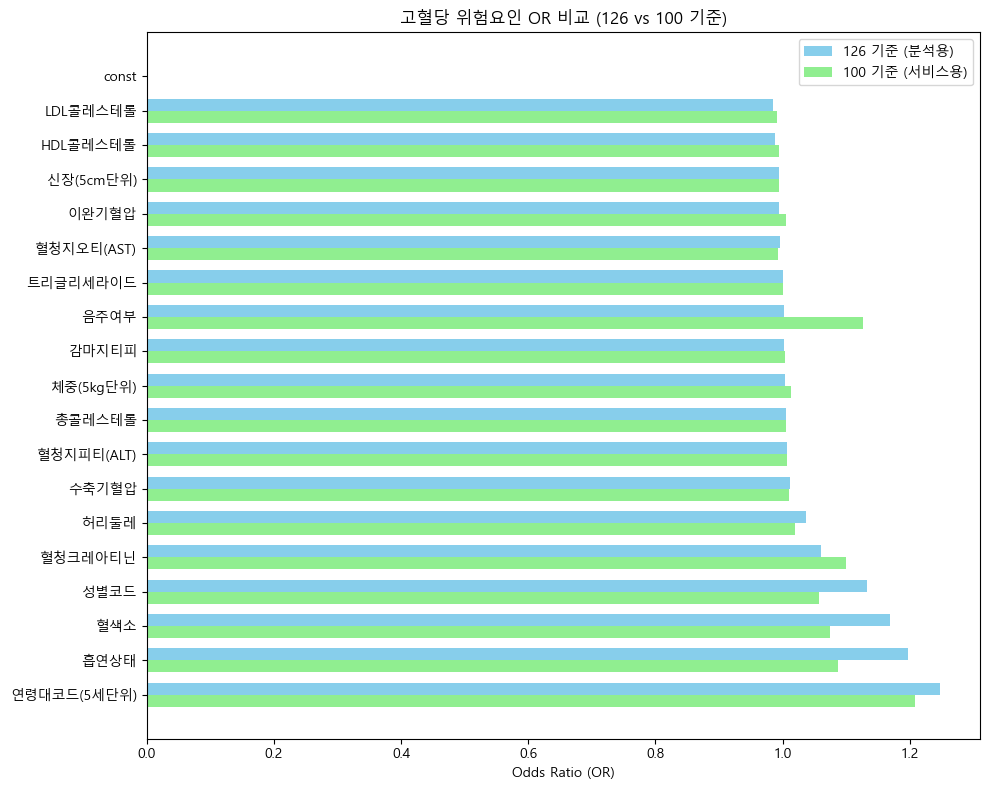

In [16]:
merged = summary_126[['변수','OR (exp(β))']].merge(
    summary_100[['변수','OR (exp(β))']],
    on='변수',
    suffixes=('_126','_100')
)


merged = merged.sort_values('OR (exp(β))_126', ascending=False)


plt.figure(figsize=(10,8))
bar_width = 0.35
x = range(len(merged))

plt.barh([i+bar_width for i in x], merged['OR (exp(β))_126'], 
         height=bar_width, label='126 기준 (분석용)', color='skyblue')
plt.barh(x, merged['OR (exp(β))_100'], 
         height=bar_width, label='100 기준 (서비스용)', color='lightgreen')

plt.yticks([i+bar_width/2 for i in x], merged['변수'])
plt.xlabel("Odds Ratio (OR)")
plt.title("고혈당 위험요인 OR 비교 (126 vs 100 기준)")
plt.legend()
plt.tight_layout()
plt.show()

## 1. 타깃 변수 생성

126 이상 → 고혈당_분석용 (학술·의학 기준)

100 이상 → 고혈당_서비스용 (사용자 위험 신호 기준)

## 2. 설명 변수 준비

신체지표: 연령, 신장, 체중, 허리둘레

혈압/혈액/지질: 혈압, 콜레스테롤, 혈색소, 간·신장 관련 수치

생활습관: 성별, 흡연, 음주

## 3. 전처리

결측치 처리:

수치형 → 중앙값 대체

범주형 → 최빈값 대체

범주형 인코딩: 성별·흡연·음주 → 더미변수(dummy variable) 처리

## 4. 로지스틱 회귀 분석

run_logit() 함수 정의 → β(회귀계수), OR(오즈비), p-value 자동 계산

126 기준 모델과 100 기준 모델을 각각 학습

## 5. 결과 활용

p-value → 유의한 변수 선별

OR(오즈비) → 변수별 위험도 해석

자가 테스트/예상 혈당 모델 설계 근거로 사용 가능

# 인사이트 정리

1. **나이(연령대코드)**는 두 기준 모두에서 가장 강력한 위험요인
OR이 1.2 이상으로 다른 변수들보다 확연히 큼.
즉, 연령이 증가할수록 혈당 이상 확률이 크게 높아짐.
따라서 서비스에서는 나이대별 맞춤 관리 기능을 제공하면 신뢰도가 높아짐. (예: 20대 예방 → 50대 이후 집중 관리)

2. 허리둘레·혈압·간 수치(ALT, AST, 감마GTP) 역시 일관된 위험 요인
생활습관(운동 부족, 복부비만, 음주)과 연결.
즉, 사용자가 체중·허리둘레·혈압만 입력해도 고위험군 예측 가능.
실측데이터가 없는 일반인 자가테스트용으로 활용하기 딱 좋음.

3. 콜레스테롤 계열 변수의 방향성 차이
LDL, HDL은 OR<1 → 고혈당과 역상관 (높으면 오히려 보호 효과로 나타남).
하지만 총콜레스테롤은 OR>1로 약간 위험요인.
사용자에게 단순히 "콜레스테롤 높다=위험"이 아니라, LDL/HDL 균형을 강조하는 교육적 기능을 넣는 게 좋음.

4. 생활습관 요인(흡연·음주)의 민감도 차이
126 기준: 음주효과(OR≈1.00) → 영향이 크지 않음.
100 기준: 음주 OR=1.12 → 서비스용에서 음주 영향이 두드러짐.
일반인 눈높이에서는 "음주가 혈당 관리에 나쁘다"는 메시지가 설득력 있게 전달됨.
분석용(의학적 기준)에서는 상대적으로 음주보다는 나이·복부비만이 핵심.

5. 체중은 기준에 따라 해석 달라짐

126 기준: 체중 OR=1.003 → 거의 영향 없음.

100 기준: 체중 OR=1.013 → 통계적으로 의미 있음.

체중은 **고혈당 위험을 민감하게 보는 사용자 기준(100)**에서는 강조할 수 있음.
즉, "체중 5kg 늘면 위험이 조금씩 증가"라는 생활 친화형 메시지 가능.

In [17]:
def calculate_risk(age_code=None, waist=None, sex=None,
                   ldl=None, tg=None, gtp=None, smoke=None,
                   hb=None, drink=None, survey_mode=False):
    """
    age_code: 5세 단위 연령코드 (예: 8=40대, 10=50대)
    waist: 허리둘레(cm)
    sex: 1=남, 2=여
    ldl: LDL 콜레스테롤
    tg: 트리글리세라이드
    gtp: 감마지티피
    smoke: 0=비흡연, 2=과거흡연, 3=현재흡연
    hb: 혈색소
    drink: 0=비음주, 1=음주
    survey_mode: True면 설문 모드(자가 응답 기반), False면 검진 데이터 기반
    """
    score = 0
    
    
    if age_code:
        if age_code >= 10: score += 2   # 50대 이상
        elif age_code >= 8: score += 1  # 40대

    
    if waist and sex:
        if (sex == 1 and waist >= 90) or (sex == 2 and waist >= 85):
            score += 3

    
    if ldl:
        if ldl >= 160: score += 2
        elif ldl >= 130: score += 1
    elif survey_mode:  # 설문용: "기름진 음식 자주 먹는다" → LDL 고위험 가정
        score += 1

    
    if tg:
        if tg >= 200: score += 2
        elif tg >= 150: score += 1
    elif survey_mode:  # 설문용: "단 음식/야식 자주" → TG 고위험 가정
        score += 1

    
    if gtp:
        if gtp >= 70: score += 2
        elif gtp >= 40: score += 1
    elif survey_mode:  # 설문용: "술 자주 마심" → gtp 위험 반영
        score += 1

    
    if smoke == 3: score += 2
    elif smoke == 2: score += 1

    
    if hb and sex:
        if (sex == 1 and hb > 17) or (sex == 2 and hb > 15.5):
            score += 1

    
    if drink == 1: score += 1

    
    if score >= 7:
        level = "위험"
    elif score >= 4:
        level = "경고"
    else:
        level = "주의"

    return score, level


In [18]:
survey_dict = {
    "version": "1.0",
    "title": "혈당 자가 위험도 테스트",
    "sections": [
        {
            "id": "basic",
            "title": "기본 정보",
            "fields": [
                {
                    "id": "age_code",
                    "label": "연령대",
                    "type": "select",
                    "options": [
                        {"label": "20-39세", "value": 6},
                        {"label": "40-49세", "value": 8},
                        {"label": "50세 이상", "value": 10}
                    ]
                },
                {
                    "id": "sex",
                    "label": "성별",
                    "type": "radio",
                    "options": [
                        {"label": "남성", "value": 1},
                        {"label": "여성", "value": 2}
                    ]
                },
                {
                    "id": "waist",
                    "label": "허리둘레(cm)",
                    "type": "number",
                    "optional": True
                }
            ]
        },
        {
            "id": "lifestyle",
            "title": "생활습관",
            "fields": [
                {
                    "id": "smoke",
                    "label": "흡연 여부",
                    "type": "radio",
                    "options": [
                        {"label": "비흡연", "value": 0},
                        {"label": "과거 흡연", "value": 2},
                        {"label": "현재 흡연", "value": 3}
                    ]
                },
                {
                    "id": "drink",
                    "label": "음주 여부",
                    "type": "radio",
                    "options": [
                        {"label": "아니오", "value": 0},
                        {"label": "예", "value": 1}
                    ]
                }
            ]
        },
        {
            "id": "lab",
            "title": "건강검진 수치 (선택 입력)",
            "fields": [
                {"id": "ldl", "label": "LDL 콜레스테롤 (mg/dL)", "type": "number", "optional": True},
                {"id": "tg", "label": "트리글리세라이드 (mg/dL)", "type": "number", "optional": True},
                {"id": "gtp", "label": "감마지티피 (U/L)", "type": "number", "optional": True},
                {"id": "hb", "label": "혈색소 (g/dL)", "type": "number", "optional": True}
            ]
        }
    ],
    "submit": {
        "label": "위험도 계산하기",
        "action": "/api/calculate_risk"
    }
}

print(survey_dict["title"])
for sec in survey_dict["sections"]:
    print(f"- {sec['title']} ({len(sec['fields'])}개 질문)")

혈당 자가 위험도 테스트
- 기본 정보 (3개 질문)
- 생활습관 (2개 질문)
- 건강검진 수치 (선택 입력) (4개 질문)


In [19]:
def risk_score(row):
    score = 0
    
    
    if row['연령대코드(5세단위)'] >= 10:   # 50세 이상
        score += 2
    elif row['연령대코드(5세단위)'] >= 8:  # 40대
        score += 1

    
    if (row['성별코드'] == 1 and row['허리둘레'] >= 90) or (row['성별코드'] == 2 and row['허리둘레'] >= 85):
        score += 3

    if row['LDL콜레스테롤'] >= 160:
        score += 2
    elif row['LDL콜레스테롤'] >= 130:
        score += 1

    
    if row['트리글리세라이드'] >= 200:
        score += 2
    elif row['트리글리세라이드'] >= 150:
        score += 1

    
    if row['감마지티피'] >= 70:
        score += 2
    elif row['감마지티피'] >= 40:
        score += 1

    
    if row['흡연상태'] == 3.0:
        score += 2
    elif row['흡연상태'] == 2.0:
        score += 1

    if (row['성별코드'] == 1 and row['혈색소'] > 17) or (row['성별코드'] == 2 and row['혈색소'] > 15.5):
        score += 1

    
    if row['음주여부'] == 1.0:
        score += 1

    return score

def risk_level(score):
    if score >= 7:
        return "위험"
    elif score >= 4:
        return "경고"
    else:
        return "주의"

df['risk_score'] = df.apply(risk_score, axis=1)
df['risk_level'] = df['risk_score'].apply(risk_level)

print(df[['연령대코드(5세단위)','허리둘레','LDL콜레스테롤','트리글리세라이드','감마지티피','흡연상태','혈색소','음주여부','risk_score','risk_level']].head(20))


    연령대코드(5세단위)  허리둘레  LDL콜레스테롤  트리글리세라이드  감마지티피  흡연상태   혈색소  음주여부  \
0            13  70.0     113.0     105.0    6.0   1.0  14.7   1.0   
1            11  74.9     113.0     105.0   14.0   1.0  12.7   1.0   
2            13  74.0     113.0     105.0   17.0   1.0  13.7   1.0   
3            16  89.0     113.0     105.0   28.0   1.0  15.6   1.0   
4            11  76.0     113.0     105.0   12.0   1.0  14.8   1.0   
5            10  90.0     113.0     105.0   38.0   1.0  14.8   1.0   
6            11  78.0     113.0     105.0   40.0   1.0  15.1   1.0   
7             9  77.0     113.0     105.0   18.0   1.0  14.6   1.0   
8            10  82.5     113.0     105.0   37.0   1.0  15.9   1.0   
9            10  87.0     113.0     105.0   16.0   1.0  14.9   1.0   
10           13  87.0     113.0     105.0   24.0   1.0  15.5   0.0   
11            9  76.5     113.0     105.0   11.0   1.0  13.2   1.0   
12            7  70.4     113.0     105.0   10.0   1.0  13.0   0.0   
13            5  73.

In [20]:
target = "고혈당_분석용"   
y = df[target]

exclude_cols = [
    "고혈당_분석용", "고혈당_서비스용", "식전혈당(공복혈당)",
    "risk_level"  
]

X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.astype("float32")
y = y.astype("int")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


NameError: name 'train_test_split' is not defined

# 자가 테스트 문항/점수 체계를 데이터적으로 검증

In [21]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '변수': list(importance.keys()),
    '중요도(gain)': list(importance.values())
}).sort_values(by='중요도(gain)', ascending=False)

print("📊 변수 중요도 (XGBoost)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind='barh', x='변수', y='중요도(gain)', legend=False
)
plt.title("XGBoost 변수 중요도 (상위 20개)")
plt.show()


NameError: name 'xgb_model' is not defined

## 인사이트 해석

risk_score가 압도적

risk_score가 1125로 가장 높음 → 우리가 만든 자가진단용 점수가 모델에서 가장 강력한 예측 변수로 작동했다는 의미.

즉, 웹 서비스에서 자가테스트 기능을 제공하는 게 실제 예측 성능에도 근거가 있다는 걸 보여줌.

연령·허리둘레·성별 → 고전적 위험요인

연령대, 허리둘레, 성별이 상위권.

이건 의학적 근거와도 일치 → 나이 많을수록, 복부 비만일수록, 남성일수록 고혈당 위험 ↑.

사용자가 쉽게 이해할 수 있는 "생활 기반 위험 인자"라서 설문 항목으로 쓰기 좋음.

음주, 흡연도 상위 요인

음주여부, 흡연상태가 변수 중요도 상위권에 등장.

웹사이트 자가테스트에 포함시켜서 행동 변화 유도 메시지 줄 수 있음 ("금주·금연이 혈당 관리에 큰 영향").

임상 검사치들도 영향력 큼

LDL콜레스테롤, 감마지티피, 트리글리세라이드, 혈청지오티(AST/ALT), 혈청크레아티닌 등.

즉, 혈당만 보지 않고 대사증후군 관련 전체 프로파일이 중요하다는 걸 보여줌.

건강검진 입력을 받는다면 추가적으로 반영 가능.

의외의 요인 → 시력, 치아우식증

시력(좌/우)와 치아우식증유무도 모델이 잡아냈음.

직접적 연관은 약하지만, 전신 건강지표나 생활습관과 연관되어서 신호로 쓰였을 가능성.

인과성보다는 데이터에서 패턴을 잡은 결과로 해석.

In [22]:
target = "고혈당_분석용"   
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)

print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000



이 모델은 “고혈당 위험 예측기” 역할 → 사용자 입력(검진/설문 기반 변수)으로 고혈당 여부를 분류
평가 결과에서 **재현율(recall)**이 중요 → 실제 고혈당 환자를 놓치지 않는지 확인하는 지표

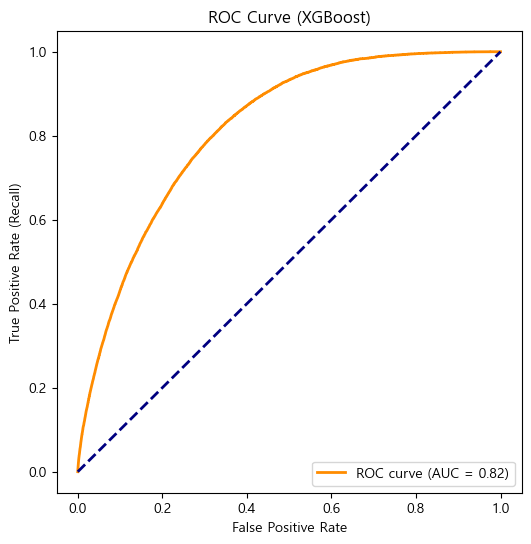

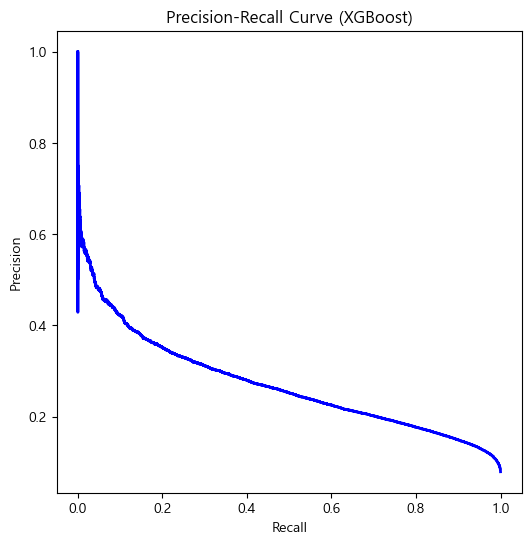

 최적 Threshold = 0.69
Precision = 0.26, Recall = 0.47, F1 = 0.34


In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend(loc="lower right")
plt.show()

prec, rec, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = f1_scores.argmax()
best_threshold = pr_thresholds[best_idx]

print(f" 최적 Threshold = {best_threshold:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")


In [24]:
target = "고혈당_분석용"
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X = X.astype("float32")
y = y.astype("int")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)

y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.show()

prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

best_thresh = thresh[np.argmax(2*prec*rec/(prec+rec+1e-6))]
print(f" 최적 Threshold = {best_thresh:.2f}")

y_pred_custom = (y_pred_proba >= best_thresh).astype(int)

print("📊 XGBoost (Threshold 조정)")
print(classification_report(y_test, y_pred_custom))


scale_pos_weight = 11.76


NameError: name 'roc_auc_score' is not defined

In [ ]:
!pip install lightgbm

In [ ]:
target = "고혈당_분석용"
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X = X.astype("float32")
y = y.astype("int")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight ≈ {scale:.2f}")

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale}
)

lgb_model.fit(X_train, y_train)

y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="orange", label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.show()

prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.show()

f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f" 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

y_pred_custom = (y_pred_proba >= best_thresh).astype(int)

print("📊 LightGBM (Threshold 조정)")
print(classification_report(y_test, y_pred_custom))

importance_df = pd.DataFrame({
    "변수": X.columns,
    "중요도": lgb_model.feature_importances_
}).sort_values(by="중요도", ascending=False)

print("\n📊 변수 중요도 (LightGBM 상위 20)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind="barh", x="변수", y="중요도", legend=False, color="green"
)
plt.title("LightGBM 변수 중요도 (상위 20)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
target = "고혈당_분석용"
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X = X.astype("float32")
y = y.astype("int")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight ≈ {scale:.2f}")

from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale}
)

lgb_model.fit(X_train, y_train)

y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="orange", label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.show()

prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.show()

f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f" 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

y_pred_best = (y_pred_proba >= best_thresh).astype(int)

print("📊 LightGBM (Threshold 조정)")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("혼동행렬 (LightGBM, 최적 Threshold)")
plt.colorbar()

classes = ["정상(0)", "고혈당(1)"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh_val = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh_val else "black")

plt.ylabel("실제값")
plt.xlabel("예측값")
plt.tight_layout()
plt.show()

importance_df = pd.DataFrame({
    "변수": X.columns,
    "중요도": lgb_model.feature_importances_
}).sort_values(by="중요도", ascending=False)

print("\n📊 변수 중요도 (LightGBM 상위 20)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind="barh", x="변수", y="중요도", legend=False, color="green"
)
plt.title("LightGBM 변수 중요도 (상위 20)")
plt.gca().invert_yaxis()
plt.show()
